# HeadHunter vacances parser

### Step 1. Specify search parameters for HeadHunter API

In [63]:
# List of different job titles for search vacancies
job_titles = [
    '1с программист'
]

# Dictionary for sinonyms
skills_synonyms = {
    # 'Менеджер продуктов': 'Product manager',
    # 'Менеджер продутка': 'Product manager',
    # 'Владелец продукта': 'Product Owner'
}

# https://api.hh.ru/specializations
specialization_ids = '1'

### Step 2. Import required libraries

In [64]:
import requests
import json
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from dateutil.relativedelta import relativedelta

### Step 3. Define simple Class with methods for parsing

In [65]:
class Parser(object):

    def __init__(self, job_titles, skills_synonyms, specialization_ids):

        # HH Endpoint
        self.__url = 'https://api.hh.ru'

        # Range of dates for search vacancies
        self.__dt_from = (datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d')
        self.__dt_to = datetime.today().strftime('%Y-%m-%d')

        # Types of experiences
        self.__experience = ['noExperience', 'between1And3', 'between3And6', 'moreThan6']

        self.__job_titles = job_titles
        self.__skills_synonyms = skills_synonyms
        self.__specialization_ids = specialization_ids


    # Private methods

    def _get_vacancies_params(self, text, experience, page=0, per_page=100) -> dict:
        '''Returns params in dictionary for GET /vacancies request
           https://github.com/hhru/api/blob/master/docs/vacancies.md
        '''

        params = {
            'text': text,
            'date_from': self.__dt_from,
            'date_to': self.__dt_to,
            'experience': experience,
            'page': page,
            'per_page': per_page,
            'currency': 'RUR',
            'responses_count_enabled': True,
            'premium': True
        }

        if self.__specialization_ids:
            params['specialization'] = self.__specialization_ids

        return params


    def _get_vacancies_text(self) -> str:
        ''' Returns correct format text param for GET /vacancies request
        '''

        job_titles = ' OR '.join([f'\'{str(e)}\'' for e in self.__job_titles])

        return f'NAME:({job_titles})'


    def _get_vacancies_req(self, params) -> dict:
        '''Wrapper for GET /vacancies API request
        '''

        r = requests.get(url = f'{self.__url}/vacancies', params = params)
        data = r.json()

        return data


    def _get_vacancy_by_id(self, id: int) -> dict:
        '''Wrapper for GET /vacancies/{vacancy_id} API request
        '''

        r = requests.get(url = f'{self.__url}/vacancies/{id}')
        data = r.json()

        return data


    def _get_items_id(self, items: list) -> list:

        return [item['id'] for item in items]


    # Public methods

    def get_vacancies(self) -> pd.DataFrame:
        '''Main function which returns DataFrame with vacancies
        '''

        df = pd.DataFrame()
        text = self._get_vacancies_text()

        for exp in self.__experience:
            print(f'\nFor Experience = \'{exp}\'')

            params = self._get_vacancies_params(text, exp)
            resp = self._get_vacancies_req(params)

            items_id = self._get_items_id(resp['items'])
            pages = resp['pages']

            # Send request for every page
            for page in tqdm(range(1, pages), position=0, desc='Step (1/2): page\'s process'):

                params = self._get_vacancies_params(text, exp, page)
                resp = self._get_vacancies_req(params)
                items_id += self._get_items_id(resp['items'])

            # Send request for every vacancy
            items = [self._get_vacancy_by_id(id) for id in tqdm(items_id, position=0, desc='Step (2/2): vacancies process')]

            df_items = pd.DataFrame(items)
            df_items['experience'] = exp

            df = pd.concat([df, df_items])

        return df

## Define simple Class for analyse vacancies

In [189]:
class Analysis(object):

    def __init__(self, vacancies: pd.DataFrame):
        self.__vacancies = vacancies.copy()
        self._clean_vacancies()


    # Private methods

    def _convert_experience(self, exp: str) -> str:
        convert = {
            'noExperience': 'Без опыта',
            'between1And3': 'Опыт 1-3 года',
            'between3And6': 'Опыт 3-6 лет',
            'moreThan6': 'Опыт 6+ лет',
        }

        if exp in convert:
            return convert[exp]
        else:
            return 'Other'


    def _convert_salary(self, salary) -> tuple:

        salary_from, salary_to = np.nan, np.nan

        if salary and salary['currency'] == 'RUR':
            salary_from = salary['from'] if salary['from'] != None else np.nan
            salary_to = salary['to'] if salary['to'] != None else np.nan

        return (salary_from, salary_to)


    def _calculate_freq(skills_series: pd.Series, max_size=20) -> tuple:
        if len(skills_series) == 0:
            return (), ()

        skills_count = skills_series.explode().value_counts()

        if max_size is not None:
            skills_count = skills_count.head(max_size)

        return skills_count.index, skills_count.values


    def _clean_vacancies(self):

        # choose right columns only
        self.__vacancies = self.__vacancies[['id', 'published_at', 'name', 'area',
                                             'salary', 'employer', 'type', 'experience',
                                             'description', 'key_skills', 'alternate_url',
                                             'schedule', 'employment', 'contacts']]

        self.__vacancies = self.__vacancies[self.__vacancies['id'].notna()]

        # convert 'area' json to string
        convert_area = lambda area: area['name'] if 'name' in area else np.nan
        self.__vacancies['area'] = self.__vacancies['area'].apply(convert_area).astype('string')

        # convert Employer name from json to strinng
        convert_employer = lambda employer: employer['name'] if 'name' in employer else np.nan
        self.__vacancies['employer'] = self.__vacancies['employer'].apply(convert_employer).astype('string')

        # convert 'key_skills' to list
        convert_skills = lambda skills: [skill['name'] if skill['name'] not in skills_synonyms
                                         else skills_synonyms[skill['name']] for skill in skills]
        self.__vacancies['key_skills'] = self.__vacancies['key_skills'].apply(convert_skills)

        # convert 'type' json to string
        convert_type = lambda tp: tp['name'] if 'name' in tp else np.nan
        self.__vacancies['type'] = self.__vacancies['type'].apply(convert_type).astype('string')

        # convert other fields
        self.__vacancies['id'] = self.__vacancies['id'].astype('int')
        self.__vacancies['published_at'] =  pd.to_datetime(self.__vacancies['published_at'],
                                                           format='%Y-%m-%dT%X%z')
        self.__vacancies['name'] = self.__vacancies['name'].astype('string')
        self.__vacancies['alternate_url'] = self.__vacancies['alternate_url'].astype('string')
        self.__vacancies['description_cleaned'] = self.__vacancies['description'].astype('string')

        # convert experience field to new format
        self.__vacancies['experience'] = self.__vacancies['experience'].apply(self._convert_experience).astype('string')


        # convert Salaris to RUR
        self.__vacancies['salary'] = self.__vacancies['salary'].apply(self._convert_salary)
        self.__vacancies[['salary_from', 'salary_to']] = pd.DataFrame(self.__vacancies['salary'].tolist(),
                                                                      index=self.__vacancies.index)
        self.__vacancies.drop(columns=['salary'], inplace=True)


        # convert 'schedule' json to string
        convert_schedule = lambda schedule: schedule['name'] if 'name' in schedule else np.nan
        self.__vacancies['schedule'] = self.__vacancies['schedule'].apply(convert_schedule).astype('string')


        # convert 'employment' json to string
        convert_employment = lambda employment: employment['name'] if 'name' in employment else np.nan
        self.__vacancies['employment'] = self.__vacancies['employment'].apply(convert_employment).astype('string')


    # Properties

    @property
    def vacancies_count(self):
        return len(self.__vacancies.index)


    # Public methods

    def get_vacancie(self, id: int):
        try:
            result = self.__vacancies.iloc[0]

        except Exception as e:
            result = f'{e}'

        return result


    def show_open_vacancies(self):

        df = self.__vacancies.groupby(['type']).size()
        print(df)


    def show_vacancies_with_contacts(self):

        wo_contacts_cnt = len(self.__vacancies[self.__vacancies['contacts'].isna()].index)
        w_contacts_cnt = len(self.__vacancies[self.__vacancies['contacts'].notna()].index)

        print(f'Vacancies with contacts: {wo_contacts_cnt}')
        print(f'Vacancies without contacts: {w_contacts_cnt}')


    def show_experience(self):

        df = self.__vacancies.groupby(['experience']).size()
        x = df.index.to_list()
        y = df.to_list()

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle('Количество вакансий с учетом опыта', fontsize=14)

        axs[0].bar(x, y)
        axs[0].set_xlabel('Опыт')
        axs[0].set_ylabel('Количество')

        rects = axs[0].patches
        labels = df.to_list()

        for rect, label in zip(rects, labels):
            height = rect.get_height()
            axs[0].text(rect.get_x() + rect.get_width() / 2, height,
                        label, ha='center', va='bottom')

        patches, texts, pcts = axs[1].pie(y, labels=x, autopct='%.1f%%',
                                          textprops={'size': 'medium'}, startangle=90)
        print(texts)



    def show_cities(self, count: int):
        sorted_10 = self.__vacancies.groupby(['area']).size() \
                        .sort_values(ascending=False)[:count]

        grouped = self.__vacancies[self.__vacancies['area'].isin(sorted_10.index.tolist())] \
                    .groupby(['area', 'experience']).size()

        # Построение баров по горизонтали
        grouped.unstack().reindex(index=sorted_10.index) \
            .plot(kind='barh', figsize=(12, 6), stacked=True)

        plt.title(f'Топ {count} городов по количеству вакансий', fontsize=14, pad=20)
        plt.legend(['Опыт 1-3 года', 'Опыт 3-6 лет', 'Опыт 6+ лет',
                    'Без опыта'], fontsize=12)

        # Инвертирование направления оси y
        plt.gca().invert_yaxis()

        plt.show()


    def show_skills(self):

        fig, axs = plt.subplots(3, 2, figsize=(20,15))

        # all vacancies
        x, y = self._calculate_freq(self.__vacancies['key_skills'])
        axs[0, 0].barh(x, y)
        axs[0, 0].set_title('Все вакансии')

        # junior
        x, y = self._calculate_freq(self.__vacancies[self.__vacancies['experience'] == 'Без опыта']['key_skills'])
        axs[1, 0].barh(x, y)
        axs[1, 0].set_title('Без опыта')

        # junior+
        x, y = self._calculate_freq(self.__vacancies[self.__vacancies['experience'] == 'Опыт 1-3 года']['key_skills'])
        axs[1, 1].barh(x, y)
        axs[1, 1].set_title('Опыт 1-3 года')

        # middle
        x, y = self._calculate_freq(self.__vacancies[self.__vacancies['experience'] == 'Опыт 3-6 лет']['key_skills'])
        axs[2, 0].barh(x, y)
        axs[2, 0].set_title('Опыт 3-6 лет')

        # senior
        x, y = self._calculate_freq(self.__vacancies[self.__vacancies['experience'] == 'Опыт 6+ лет']['key_skills'])
        axs[2, 1].barh(x, y)
        axs[2, 1].set_title('Опыт 6+ лет')

        fig.tight_layout()


    def show_job_titles(self, count: int):

        x = self.__vacancies.groupby(['name']).size() \
                .sort_values(ascending=False)[:count].plot(kind='bar', figsize=(12, 6), stacked=True)

        plt.title(f'Топ {count} названий вакансий по количеству', fontsize=14, pad=20)
        plt.show()


    def show_companies(self, count: int):

        sorted_5 = self.__vacancies.groupby(['employer']).size() \
                       .sort_values(ascending=False)[:count]

        grouped = self.__vacancies[self.__vacancies['employer'].isin(sorted_5.index.tolist())] \
                      .groupby(['employer', 'experience']).size()

        grouped.reindex(index=sorted_5.index, level=0).unstack() \
               .plot(kind='bar', figsize=(12, 6), stacked=True)

        plt.title(f'Топ {count} компаний по количеству вакансий', fontsize=14, pad=20)
        plt.show()


    def show_shedule(self):

        sorted_5 = self.__vacancies.groupby(['schedule']).size().sort_values(ascending=False)
        grouped = self.__vacancies[self.__vacancies['schedule'].isin(sorted_5.index.tolist())] \
                      .groupby(['schedule', 'experience']).size()

        grouped.reindex(index=sorted_5.index, level=0).unstack() \
               .plot(kind='bar', figsize=(12, 6), stacked=True)

        plt.title(f'Удаленная работа / Полный день', fontsize=14, pad=20)
        plt.show()


    def show_employment(self):
        sorted_5 = self.__vacancies.groupby(['employment']).size().sort_values(ascending=False)
        grouped = self.__vacancies[self.__vacancies['employment'].isin(sorted_5.index.tolist())] \
                      .groupby(['employment', 'experience']).size()

        grouped.reindex(index=sorted_5.index, level=0).unstack() \
               .plot(kind='bar', figsize=(12, 6), stacked=True)

        plt.title(f'Employment', fontsize=14, pad=20)
        plt.show()


    def show_salary(self):

        df_with_salary = self.__vacancies[(~self.__vacancies['salary_from'].isnull()) | \
                                          (~self.__vacancies['salary_to'].isnull())]

        df_wo_salary = self.__vacancies[(self.__vacancies['salary_from'].isnull()) & \
                                        (self.__vacancies['salary_to'].isnull())]

        labels = ['С зарплатой', 'Без зарплаты']

        patches, texts, pcts = plt.pie([len(df_with_salary.index), len(df_wo_salary.index)],
                                       autopct='%.1f%%', textprops={'size': 'medium'},
                                       startangle=90, pctdistance=1.12, explode=[0.03, 0])

        plt.rcParams['figure.figsize'] = (20, 6)
        plt.title('Доля вакансий с указанной зарплатой', fontsize=14, pad=20)
        plt.legend(labels=labels, loc='upper right', fontsize=12)

        plt.show()


    def show_salary_boxplot(self):

        df_with_salary = self.__vacancies[(~self.__vacancies['salary_from'].isnull()) | \
                                          (~self.__vacancies['salary_to'].isnull())]

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Без опыта']
        s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
        jun_salary = s_tmp[~s_tmp.isnull()]

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Опыт 1-3 года']
        s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
        jun_plus_salary = s_tmp[~s_tmp.isnull()]

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Опыт 3-6 лет']
        s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
        middle_salary = s_tmp[~s_tmp.isnull()]

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Опыт 6+ лет']
        s_tmp = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index = True)
        senior_salary = s_tmp[~s_tmp.isnull()]


        fig = plt.figure(figsize =(16, 6))
        ax = fig.add_axes([0, 0, 1, 1])

        labels = ['Без опыта', 'Опыт 1-3 года',
                'Опыт 3-6 лет', 'Опыт 6+ лет']

        ax.boxplot([jun_salary, jun_plus_salary, middle_salary, senior_salary],
                labels=labels, vert=False)


    def download_csv(self):
        self.__vacancies.to_csv('vacancies.csv')
        files.download('vacancies.csv')

In [349]:
class Analysis(object):

    def __init__(self, vacancies: pd.DataFrame):
        self.__vacancies = vacancies.copy()
        self._clean_vacancies()


    # Private methods

    def _convert_experience(self, exp: str) -> str:
        convert = {
            'noExperience': 'Без опыта',
            'between1And3': 'Опыт 1-3 года',
            'between3And6': 'Опыт 3-6 лет',
            'moreThan6': 'Опыт 6+ лет',
        }

        if exp in convert:
            return convert[exp]
        else:
            return 'Other'


    def _convert_salary(self, salary) -> tuple:

        salary_from, salary_to = np.nan, np.nan

        if salary and salary['currency'] == 'RUR':
            salary_from = salary['from'] if salary['from'] != None else np.nan
            salary_to = salary['to'] if salary['to'] != None else np.nan

        return (salary_from, salary_to)


    def _calculate_freq(self, df: pd.DataFrame, max_size=20) -> tuple:

        if len(df) == 0:
            return (0, 0)

        skills_dict = {}

        for row in df.iteritems():
            skills = row[1]
            for skill in skills:
                if skill in skills_dict:
                    skills_dict[skill] += 1
                else:
                    skills_dict[skill] = 1

        if len(skills_dict) < max_size:
            max_size = len(skills_dict)

        skills_dict = dict(sorted(skills_dict.items(), key=lambda item: item[1], reverse=True))

        return (list(skills_dict.keys())[:max_size][::-1],
                list(skills_dict.values())[:max_size][::-1])


    def _clean_vacancies(self):

        # choose right columns only
        self.__vacancies = self.__vacancies[['id', 'published_at', 'name', 'area',
                                             'salary', 'employer', 'type', 'experience',
                                             'description', 'key_skills', 'alternate_url',
                                             'schedule', 'employment', 'contacts']]

        self.__vacancies = self.__vacancies[self.__vacancies['id'].notna()]

        # convert 'area' json to string
        convert_area = lambda area: area['name'] if 'name' in area else np.nan
        self.__vacancies['area'] = self.__vacancies['area'].apply(convert_area).astype('string')

        # convert Employer name from json to strinng
        convert_employer = lambda employer: employer['name'] if 'name' in employer else np.nan
        self.__vacancies['employer'] = self.__vacancies['employer'].apply(convert_employer).astype('string')

        # convert 'key_skills' to list
        convert_skills = lambda skills: [skill['name'] if skill['name'] not in skills_synonyms
                                         else skills_synonyms[skill['name']] for skill in skills]
        self.__vacancies['key_skills'] = self.__vacancies['key_skills'].apply(convert_skills)

        # convert 'type' json to string
        convert_type = lambda tp: tp['name'] if 'name' in tp else np.nan
        self.__vacancies['type'] = self.__vacancies['type'].apply(convert_type).astype('string')

        # convert other fields
        self.__vacancies['id'] = self.__vacancies['id'].astype('int')
        self.__vacancies['published_at'] =  pd.to_datetime(self.__vacancies['published_at'],
                                                           format='%Y-%m-%dT%X%z')
        self.__vacancies['name'] = self.__vacancies['name'].astype('string')
        self.__vacancies['alternate_url'] = self.__vacancies['alternate_url'].astype('string')
        self.__vacancies['description_cleaned'] = self.__vacancies['description'].astype('string')

        # convert experience field to new format
        self.__vacancies['experience'] = self.__vacancies['experience'].apply(self._convert_experience).astype('string')


        # convert Salaris to RUR
        self.__vacancies['salary'] = self.__vacancies['salary'].apply(self._convert_salary)
        self.__vacancies[['salary_from', 'salary_to']] = pd.DataFrame(self.__vacancies['salary'].tolist(),
                                                                      index=self.__vacancies.index)
        self.__vacancies.drop(columns=['salary'], inplace=True)


        # convert 'schedule' json to string
        convert_schedule = lambda schedule: schedule['name'] if 'name' in schedule else np.nan
        self.__vacancies['schedule'] = self.__vacancies['schedule'].apply(convert_schedule).astype('string')


        # convert 'employment' json to string
        convert_employment = lambda employment: employment['name'] if 'name' in employment else np.nan
        self.__vacancies['employment'] = self.__vacancies['employment'].apply(convert_employment).astype('string')


    # Properties

    @property
    def vacancies_count(self):
        return len(self.__vacancies.index)


    # Public methods

    def get_vacancie(self, id: int):
        try:
            result = self.__vacancies.iloc[0]

        except Exception as e:
            result = f'{e}'

        return result


    def show_open_vacancies(self):

        df = self.__vacancies.groupby(['type']).size()
        print(df)


    def show_vacancies_with_contacts(self):

        wo_contacts_cnt = len(self.__vacancies[self.__vacancies['contacts'].isna()].index)
        w_contacts_cnt = len(self.__vacancies[self.__vacancies['contacts'].notna()].index)

        print(f'Vacancies with contacts: {wo_contacts_cnt}')
        print(f'Vacancies without contacts: {w_contacts_cnt}')


    def show_experience(self):

        df = self.__vacancies.groupby(['experience']).size()
        x = df.index.to_list()
        y = df.to_list()

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        fig.suptitle('Количество вакансий с учетом опыта', fontsize=14)

        axs[0].bar(x, y)
        axs[0].set_xlabel('Опыт')
        axs[0].set_ylabel('Количество')

        rects = axs[0].patches
        labels = df.to_list()

        for rect, label in zip(rects, labels):
            height = rect.get_height()
            axs[0].text(rect.get_x() + rect.get_width() / 2, height,
                        label, ha='center', va='bottom')

        patches, texts, pcts = axs[1].pie(y, labels=x, autopct='%.1f%%',
                                          textprops={'size': 'medium'}, startangle=90)
        print(texts)



    def show_cities(self, count: int):
        sorted_10 = self.__vacancies.groupby(['area']).size() \
                        .sort_values(ascending=False)[:count]

        grouped = self.__vacancies[self.__vacancies['area'].isin(sorted_10.index.tolist())] \
                    .groupby(['area', 'experience']).size()

        # Построение баров по горизонтали
        ax = grouped.unstack().reindex(index=sorted_10.index) \
            .plot(kind='barh', figsize=(12, 6), stacked=True)

        plt.title(f'Топ {count} городов по количеству вакансий', fontsize=14, pad=20)
        plt.legend(['Опыт 1-3 года', 'Опыт 3-6 лет', 'Опыт 6+ лет',
                    'Без опыта'], fontsize=12)
        # Добавление подписей к осям
        ax.set_xlabel('Количество вакансий', fontsize=12)
        ax.set_ylabel('Город', fontsize=12)

        # Добавление легенды
        ax.legend(title='Опыт', fontsize=10, title_fontsize=12)
        # Инвертирование направления оси y
        plt.gca().invert_yaxis()

        plt.show()


    def show_skills(self):
    # Set up subplots
        fig, axs = plt.subplots(2, 2, figsize=(16, 11))

        # List of experience levels
        experience_levels = ['Без опыта', 'Опыт 1-3 года', 'Опыт 3-6 лет', 'Опыт 6+ лет']

        for i, exp_level in enumerate(experience_levels):
            # Extract vacancies for the current experience level
            current_vacancies = self.__vacancies[self.__vacancies['experience'] == exp_level]['key_skills']

            # Calculate frequencies and get the top 7 skills
            x, y = self._calculate_freq(current_vacancies)
            x = x[:13]
            y = y[:13]

            # Plot the bar chart
            axs[i // 2, i % 2].barh(x, y)
            axs[i // 2, i % 2].set_title(exp_level)
            axs[i // 2, i % 2].set_xlabel('Количество вакансий')
            axs[i // 2, i % 2].set_ylabel('Навыки')


    def show_skills_all(self):
        # Set up subplots
        fig, axs = plt.subplots(figsize=(12, 8))

        # Extract all key skills
        all_skills = self.__vacancies['key_skills']

        # Calculate frequencies and get the top 13 skills
        x, y = self._calculate_freq(all_skills)

        # Plot the bar chart
        axs.barh(x, y)
        axs.set_title('Навыки в вакансиях')
        axs.set_xlabel('Количество вакансий')
        axs.set_ylabel('Навыки')

        plt.show()

        # Adjust layout and show the plot
        fig.tight_layout()
        plt.show()

    def show_skills_wordcloud(self):
        # Создайте текстовую строку с навыками
        skills_text = ' '.join(self.__vacancies['key_skills'].astype(str).values)

        # Инициализируйте облако тегов
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(skills_text)

        # Отобразите облако тегов
        plt.figure(figsize=(12, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Облако навыков', fontsize=16, pad=20)

        plt.show()



    def show_job_titles(self, count: int):

        x = self.__vacancies.groupby(['name']).size() \
                .sort_values(ascending=False)[:count].plot(kind='bar', figsize=(12, 6), stacked=True)

        # Добавление подписей к осям
        x.set_xlabel('Название вакансии', fontsize=12)
        x.set_ylabel('Количество вакансий', fontsize=12)

        plt.title(f'Топ {count} названий вакансий по количеству', fontsize=14, pad=20)
        plt.show()



    def show_companies(self, count: int):

        sorted_5 = self.__vacancies.groupby(['employer']).size() \
                       .sort_values(ascending=False)[:count]

        grouped = self.__vacancies[self.__vacancies['employer'].isin(sorted_5.index.tolist())] \
                      .groupby(['employer', 'experience']).size()

        ax = grouped.reindex(index=sorted_5.index, level=0).unstack() \
               .plot(kind='bar', figsize=(12, 6), stacked=True)
        # Добавление подписей к осям
        ax.set_xlabel('Компания', fontsize=12)
        ax.set_ylabel('Количество вакансий', fontsize=12)

        # Добавление легенды
        ax.legend(title='Опыт', fontsize=10, title_fontsize=12)

        plt.title(f'Топ {count} компаний по количеству вакансий', fontsize=14, pad=20)
        plt.show()


    def show_shedule(self):

        sorted_5 = self.__vacancies.groupby(['schedule']).size().sort_values(ascending=False)
        grouped = self.__vacancies[self.__vacancies['schedule'].isin(sorted_5.index.tolist())] \
                    .groupby(['schedule', 'experience']).size()

        ax = grouped.reindex(index=sorted_5.index, level=0).unstack() \
            .plot(kind='bar', figsize=(12, 6), stacked=True)

        # Добавление подписей к осям
        ax.set_xlabel('График работы', fontsize=12)
        ax.set_ylabel('Количество вакансий', fontsize=12)

        # Добавление легенды
        ax.legend(title='Опыт', fontsize=10, title_fontsize=12)

        plt.title('Удаленная работа / Полный день', fontsize=14, pad=20)
        plt.show()



    def show_employment(self):
        sorted_5 = self.__vacancies.groupby(['employment']).size().sort_values(ascending=False)
        grouped = self.__vacancies[self.__vacancies['employment'].isin(sorted_5.index.tolist())] \
                        .groupby(['employment', 'experience']).size()

        ax = grouped.reindex(index=sorted_5.index, level=0).unstack() \
            .plot(kind='bar', figsize=(12, 6), stacked=True)

        # Добавление подписей к осям
        ax.set_xlabel('Тип занятости', fontsize=12)
        ax.set_ylabel('Количество вакансий', fontsize=12)

        # Добавление легенды
        ax.legend(title='Опыт', fontsize=10, title_fontsize=12)

        plt.title('Тип занятости', fontsize=14, pad=20)
        plt.show()


    def show_salary(self):
        df_with_salary = self.__vacancies[(~self.__vacancies['salary_from'].isnull()) |
                                        (~self.__vacancies['salary_to'].isnull())]

        df_wo_salary = self.__vacancies[(self.__vacancies['salary_from'].isnull()) &
                                        (self.__vacancies['salary_to'].isnull())]

        labels = ['С зарплатой', 'Без зарплаты']

        patches, texts, pcts = plt.pie([len(df_with_salary.index), len(df_wo_salary.index)],
                                    autopct='%.1f%%', textprops={'size': 'medium'},
                                    startangle=90, pctdistance=1.12, explode=[0.03, 0])

        plt.rcParams['figure.figsize'] = (20, 6)

        # Добавление подписи к круговой диаграмме
        plt.title('Доля вакансий с указанной зарплатой', fontsize=14, pad=20)

        # Добавление легенды
        plt.legend(labels=labels, loc='upper right', fontsize=12)

        plt.show()


    def show_salary_boxplot(self):

        df_with_salary = self.__vacancies[(~self.__vacancies['salary_from'].isnull()) |
                                        (~self.__vacancies['salary_to'].isnull())]

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Без опыта']
        jun_salary = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index=True).dropna()

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Опыт 1-3 года']
        jun_plus_salary = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index=True).dropna()

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Опыт 3-6 лет']
        middle_salary = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index=True).dropna()

        df_tmp = df_with_salary[df_with_salary['experience'] == 'Опыт 6+ лет']
        senior_salary = pd.concat([df_tmp['salary_from'], df_tmp['salary_to']], ignore_index=True).dropna()

        fig, ax = plt.subplots(figsize=(12, 6))

        # Добавление ящиков с усами
        ax.boxplot([jun_salary, jun_plus_salary, middle_salary, senior_salary],
                labels=['Без опыта', 'Опыт 1-3 года', 'Опыт 3-6 лет', 'Опыт 6+ лет'],
                vert=False, widths=0.7, patch_artist=True)

        # Добавление подписей к осям
        ax.set_xlabel('Зарплата', fontsize=12)
        ax.set_yticklabels(['Без опыта', 'Опыт 1-3 года', 'Опыт 3-6 лет', 'Опыт 6+ лет'], fontsize=10)

        plt.title('Зарплата от опыта работы', fontsize=14, pad=20)

        # Вывод числовых результатов
        print("Статистика для 'Без опыта':")
        print(jun_salary.describe())

        print("\nСтатистика для 'Опыт 1-3 года':")
        print(jun_plus_salary.describe())

        print("\nСтатистика для 'Опыт 3-6 лет':")
        print(middle_salary.describe())

        print("\nСтатистика для 'Опыт 6+ лет':")
        print(senior_salary.describe())

        plt.show()




    def download_csv(self):
        self.__vacancies.to_csv('vacancies.csv')
        files.download('vacancies.csv')

In [ ]:
from sklearn.model_selection import train_test_split

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Восстановление модели на тренировочных данных
model_train = sm.OLS(y_train, X_train).fit()

# Получение предсказанных значений на тестовой выборке
predicted_values_test = model_train.predict(X_test)

In [ ]:
# Вычисление метрик на тестовой выборке
mse_test = mean_squared_error(y_test, predicted_values_test)
rmse_test = np.sqrt(mse_test)
r_squared_test = r2_score(y_test, predicted_values_test)
mae_test = mean_absolute_error(y_test, predicted_values_test)
medae_test = median_absolute_error(y_test, predicted_values_test)

print(f'Test Mean Squared Error (MSE): {mse_test:.2f}')
print(f'Test Root Mean Squared Error (RMSE): {rmse_test:.2f}')
print(f'Test R-squared: {r_squared_test:.4f}')
print(f'Test Mean Absolute Error (MAE): {mae_test:.2f}')
print(f'Test Median Absolute Error (MedAE): {medae_test:.2f}')


Test Mean Squared Error (MSE): 2466782194.14
Test Root Mean Squared Error (RMSE): 49666.71
Test R-squared: 0.5498
Test Mean Absolute Error (MAE): 39776.47
Test Median Absolute Error (MedAE): 31645.37


In [ ]:
from sklearn.model_selection import train_test_split

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Восстановление модели на тренировочных данных
model_train = sm.OLS(y_train, X_train).fit()

# Получение предсказанных значений на тестовой выборке
predicted_values_test = model_train.predict(X_test)

In [ ]:
# Вычисление метрик на тестовой выборке
mse_test = mean_squared_error(y_test, predicted_values_test)
rmse_test = np.sqrt(mse_test)
r_squared_test = r2_score(y_test, predicted_values_test)
mae_test = mean_absolute_error(y_test, predicted_values_test)
medae_test = median_absolute_error(y_test, predicted_values_test)

print(f'Test Mean Squared Error (MSE): {mse_test:.2f}')
print(f'Test Root Mean Squared Error (RMSE): {rmse_test:.2f}')
print(f'Test R-squared: {r_squared_test:.4f}')
print(f'Test Mean Absolute Error (MAE): {mae_test:.2f}')
print(f'Test Median Absolute Error (MedAE): {medae_test:.2f}')


Test Mean Squared Error (MSE): 2466782194.14
Test Root Mean Squared Error (RMSE): 49666.71
Test R-squared: 0.5498
Test Mean Absolute Error (MAE): 39776.47
Test Median Absolute Error (MedAE): 31645.37


### Step 4. Run parsing and analyse vacancies

In [141]:
# Parse vacancies
# parser = Parser(job_titles, skills_synonyms, specialization_ids)
vacancies = parser.get_vacancies()


For Experience = 'noExperience'


Step (2/2): vacancies process:  60%|█████▉    | 177/296 [00:19<00:09, 12.46it/s]

KeyboardInterrupt: 

In [350]:
# Initialise analysis object with vacancies
analysis = Analysis(vacancies)

print(f'Count of vacancies: {analysis.vacancies_count}\n')
print(f'Example:\n{analysis.get_vacancie(0)}')

Count of vacancies: 851

Example:
id                                                              90734745
published_at                                   2023-12-15 13:57:36+03:00
name                                               Стажер-программист 1С
area                                                     Санкт-Петербург
employer                                                     Глобал АйТи
type                                                            Открытая
experience                                                     Без опыта
description            <p>В молодую развивающуюся аккредитованную IT ...
key_skills                                                            []
alternate_url                             https://hh.ru/vacancy/90734745
schedule                                                     Полный день
employment                                              Полная занятость
contacts                                                             NaN
description_clean

In [241]:
!pip install wordcloud

                                              0.0/300.2 kB ? eta -:--:--
     ---                                     30.7/300.2 kB 1.4 MB/s eta 0:00:01
     ------------------                     143.4/300.2 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- 300.2/300.2 kB 2.3 MB/s eta 0:00:00


In [224]:
analysis.show_open_vacancies()

type
Анонимная      3
Открытая     848
dtype: int64


In [225]:
analysis.show_vacancies_with_contacts()

Vacancies with contacts: 851
Vacancies without contacts: 0


[Text(-0.47151480261884754, 0.9938177855680131, 'Без опыта'), Text(-0.9929457466976548, -0.473348438378154, 'Опыт 1-3 года'), Text(1.0801797622858262, -0.2078741954840383, 'Опыт 3-6 лет'), Text(0.209867628486193, 1.0797942297093375, 'Опыт 6+ лет')]


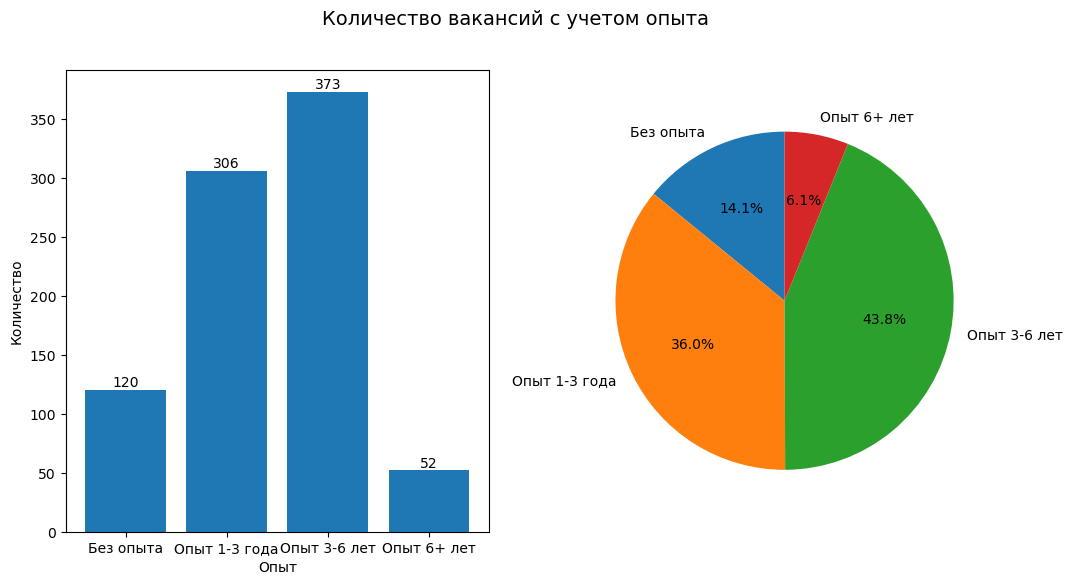

In [226]:
analysis.show_experience()

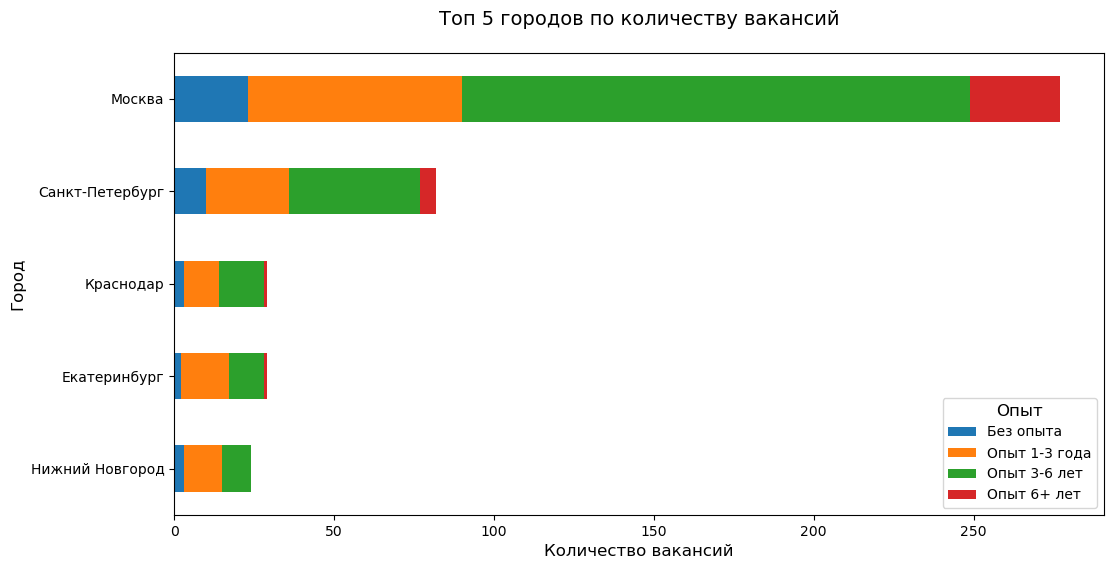

In [227]:
analysis.show_cities(5)

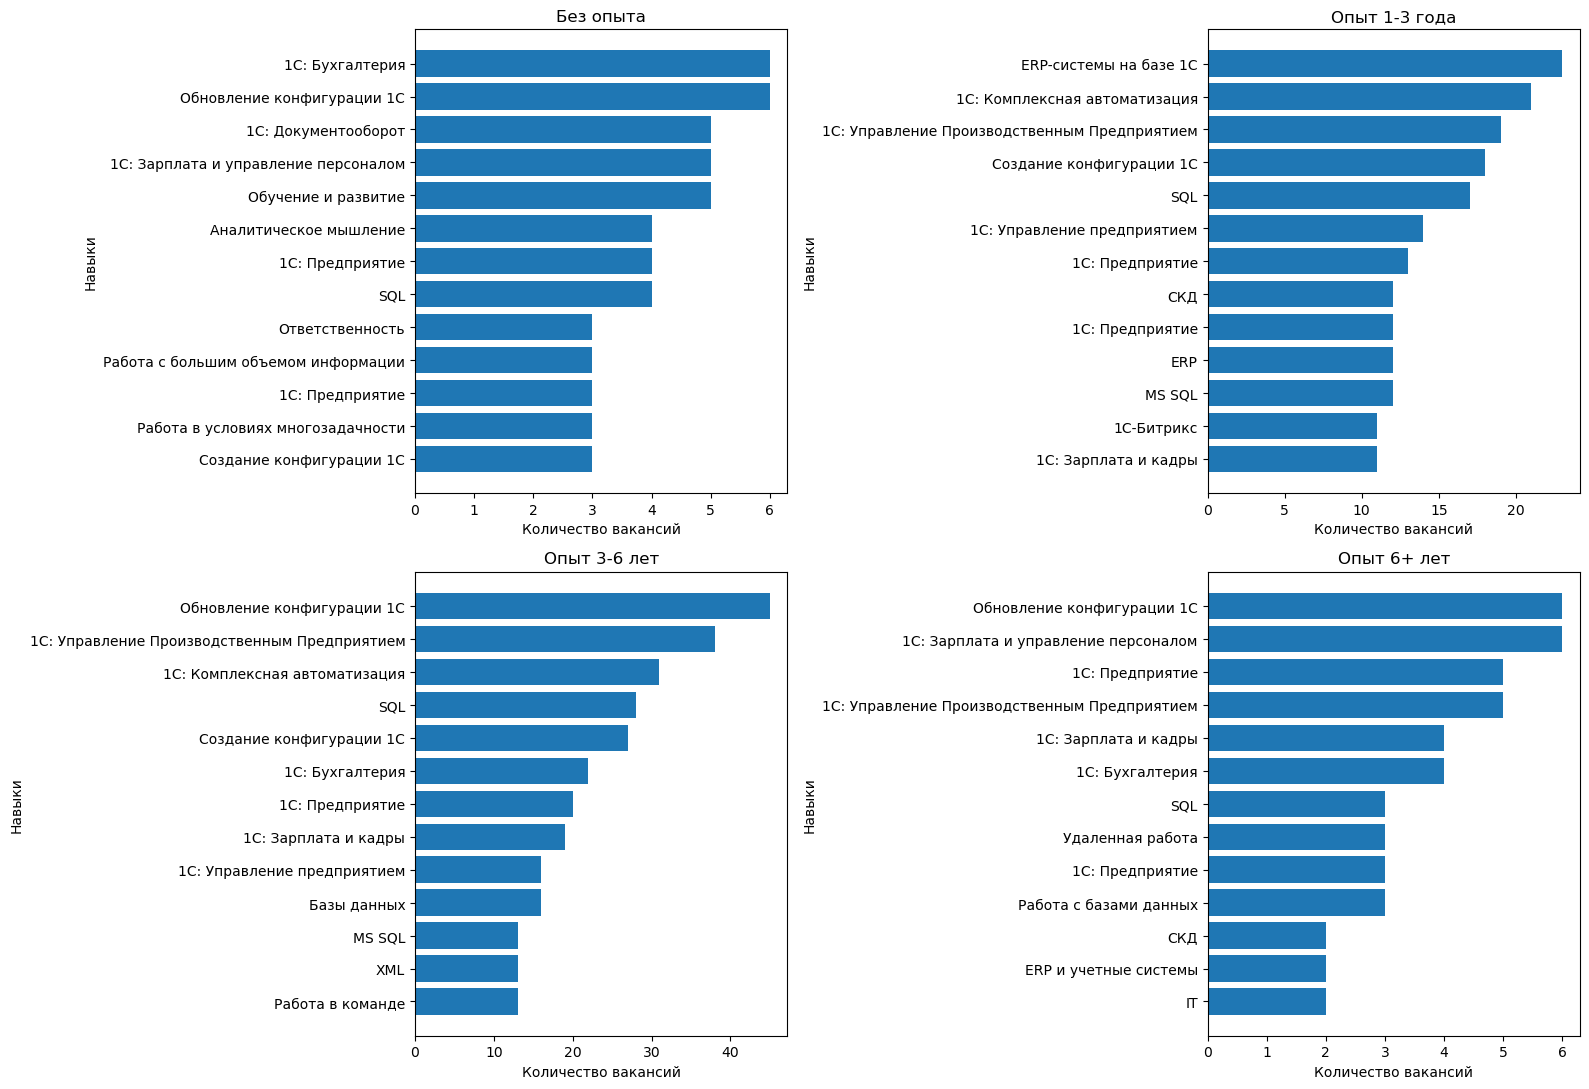

In [276]:
analysis.show_skills()

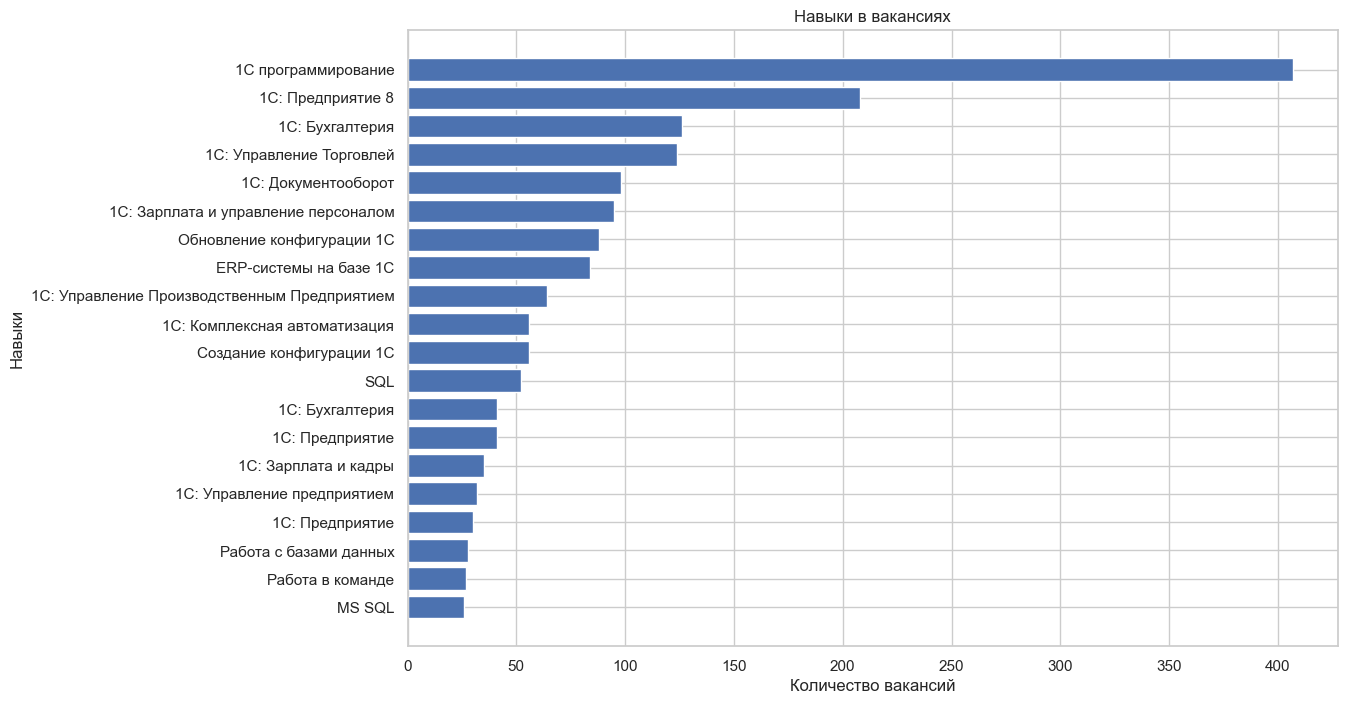

In [342]:
analysis.show_skills_all()

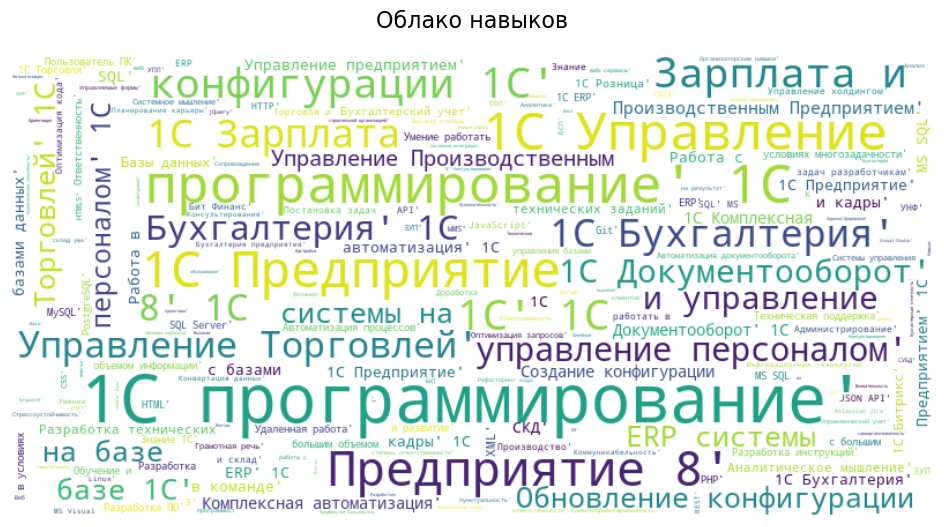

In [246]:
from wordcloud import WordCloud

analysis.show_skills_wordcloud()

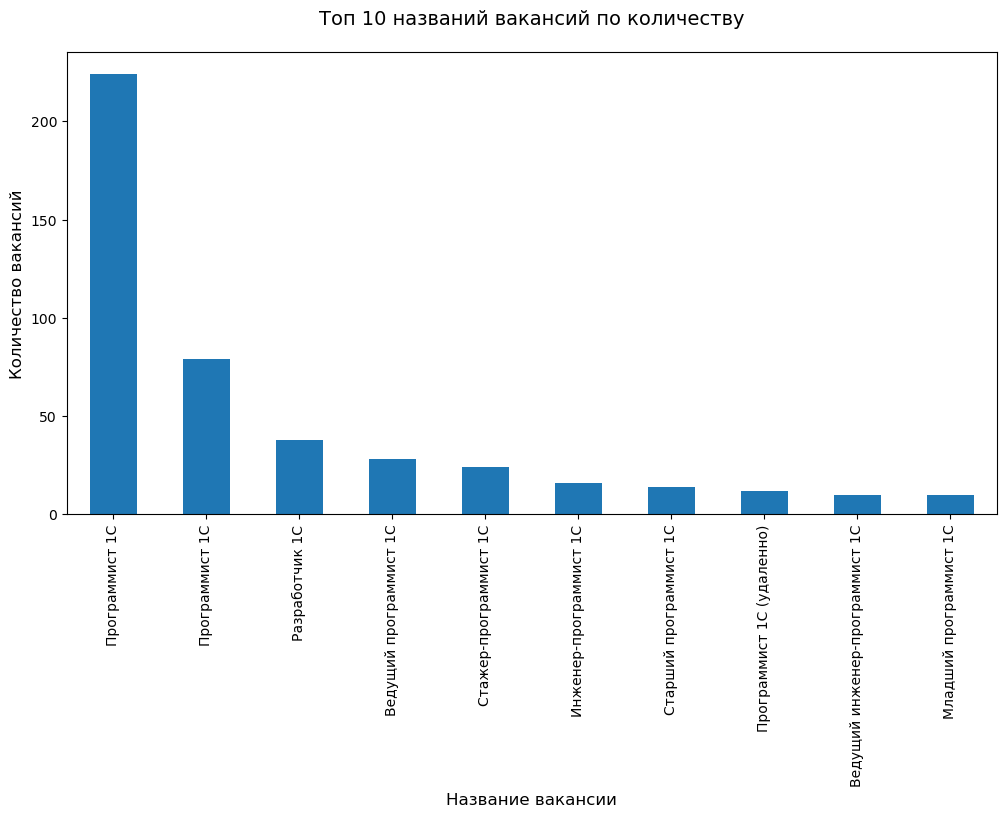

In [229]:
analysis.show_job_titles(10)

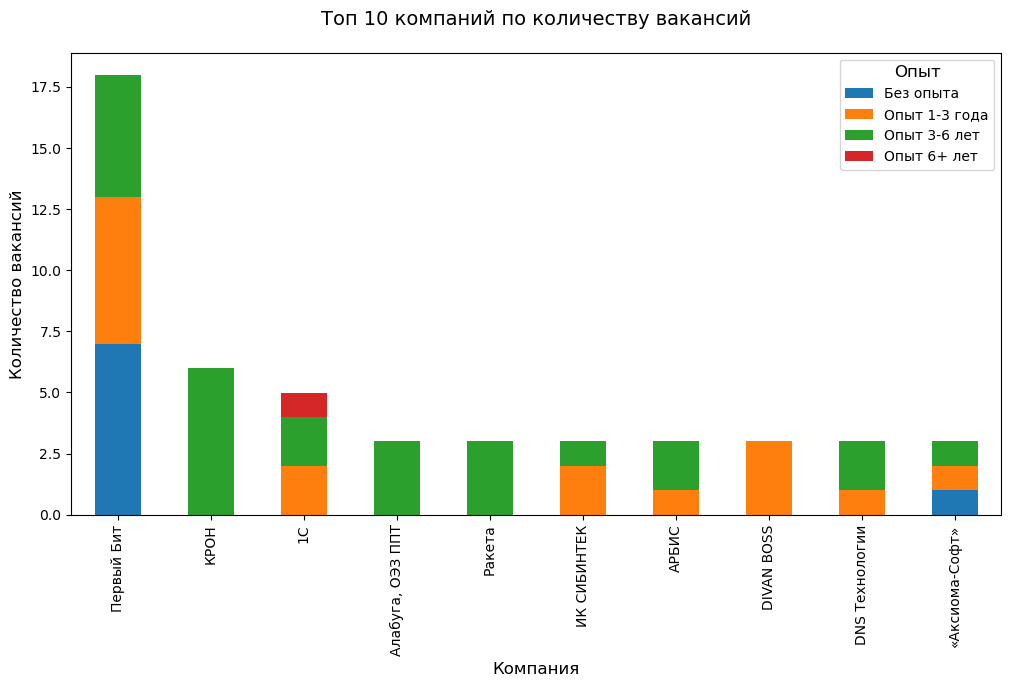

In [231]:
analysis.show_companies(10)

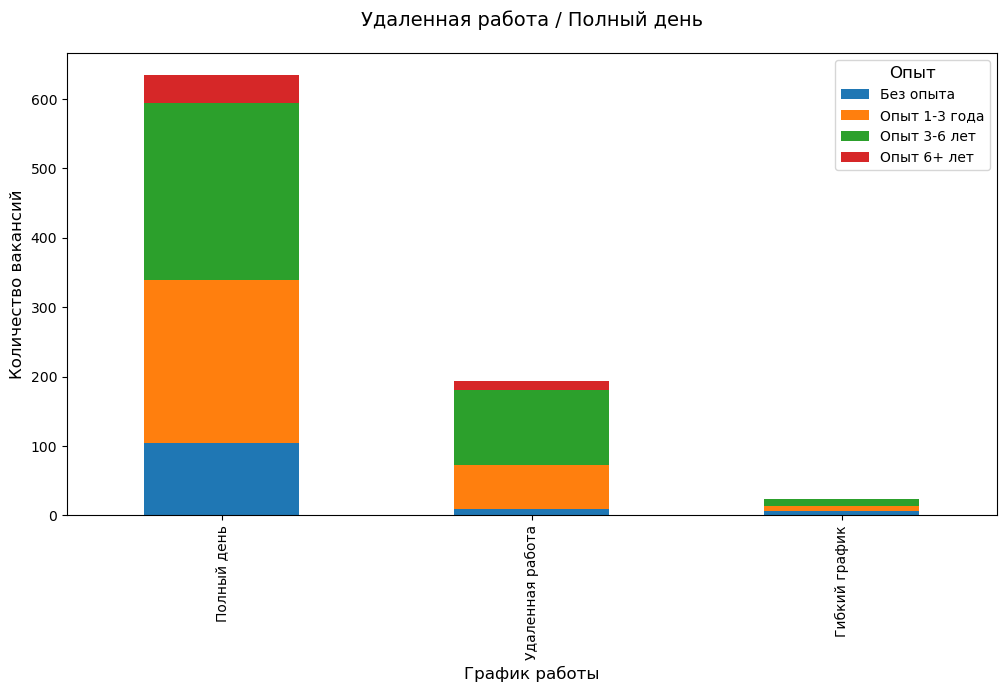

In [232]:
analysis.show_shedule()

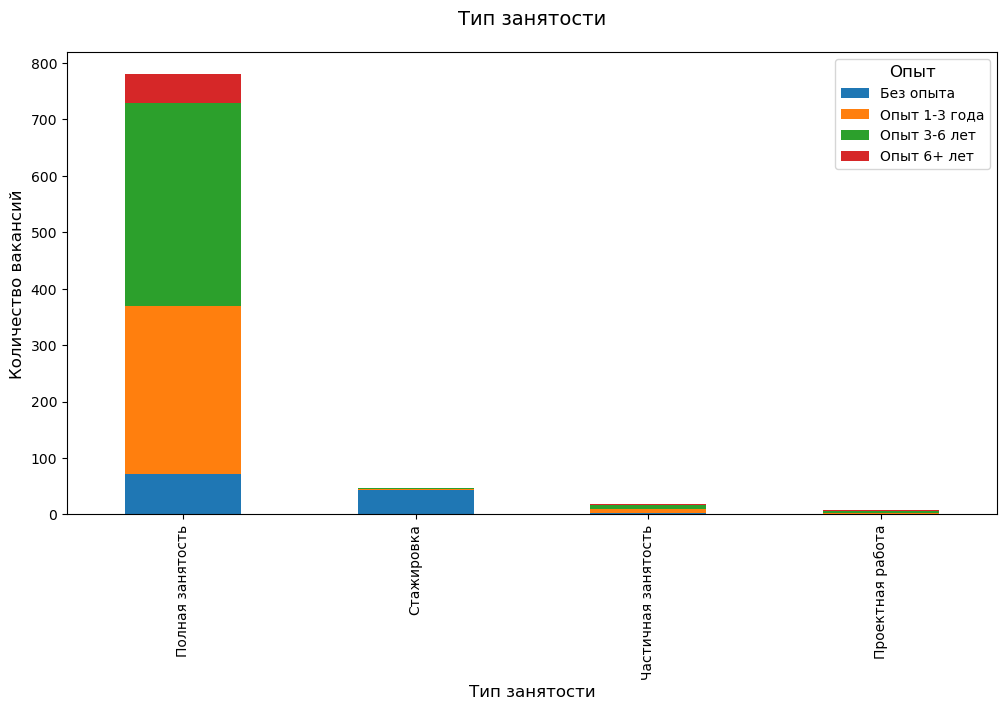

In [233]:
analysis.show_employment()

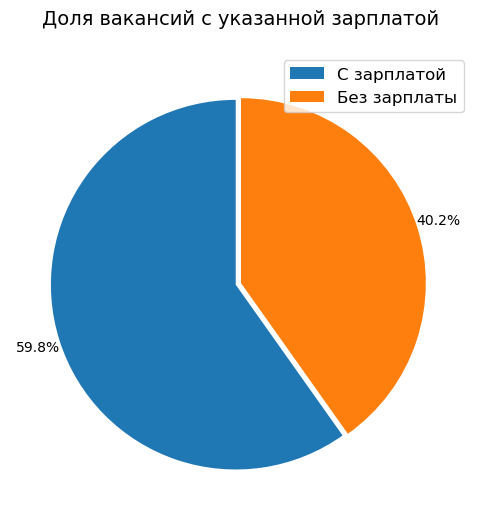

In [234]:
analysis.show_salary()

Статистика для 'Без опыта':
count       134.000000
mean      60789.552239
std       43542.314168
min       15000.000000
25%       30000.000000
50%       46650.000000
75%       70000.000000
max      220000.000000
dtype: float64

Статистика для 'Опыт 1-3 года':
count       251.000000
mean     137098.067729
std       58585.897443
min       27000.000000
25%      100000.000000
50%      130000.000000
75%      180000.000000
max      300000.000000
dtype: float64

Статистика для 'Опыт 3-6 лет':
count       321.000000
mean     192200.000000
std       69837.797789
min       40000.000000
25%      150000.000000
50%      180000.000000
75%      250000.000000
max      500000.000000
dtype: float64

Статистика для 'Опыт 6+ лет':
count        36.000000
mean     199444.444444
std       86888.909187
min       10000.000000
25%      147500.000000
50%      210000.000000
75%      252500.000000
max      350000.000000
dtype: float64


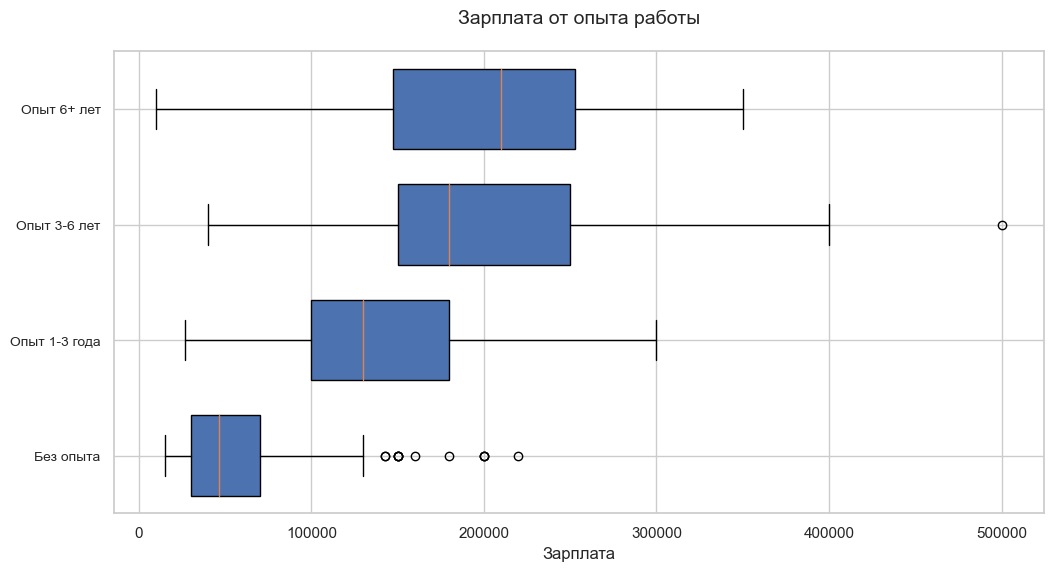

In [351]:
analysis.show_salary_boxplot()

In [93]:
analysis.download_csv()

NameError: name 'files' is not defined

In [94]:
import warnings
warnings.filterwarnings("ignore")

In [95]:
df = pd.read_csv('vacancies_1c.csv')
df.columns

Index(['Unnamed: 0', 'id', 'published_at', 'name', 'area', 'employer', 'type',
       'experience', 'description', 'key_skills', 'alternate_url', 'schedule',
       'employment', 'contacts', 'description_cleaned', 'salary_from',
       'salary_to'],
      dtype='object')

In [96]:
df.head()

,Unnamed: 0,id,published_at,name,area,employer,type,experience,description,key_skills,alternate_url,schedule,employment,contacts,description_cleaned,salary_from,salary_to
0,0,90734745,2023-12-15 13:57:36+03:00,Стажер-программист 1С,Санкт-Петербург,Глобал АйТи,Открытая,Junior (no experince),<p>В молодую развивающуюся аккредитованную IT ...,[],https://hh.ru/vacancy/90734745,Полный день,Полная занятость,NaN,<p>В молодую развивающуюся аккредитованную IT ...,40000.0,NaN
1,1,90553611,2023-12-11 12:49:07+03:00,Начинающий программист 1С (удаленно),Уфа,Группа Компаний ОЗНА,Открытая,Junior (no experince),<p><strong>ЗАДАЧИ:</strong></p> <ul> <li>Прогр...,[],https://hh.ru/vacancy/90553611,Удаленная работа,Полная занятость,NaN,<p><strong>ЗАДАЧИ:</strong></p> <ul> <li>Прогр...,30000.0,NaN
2,2,90330411,2023-12-14 12:08:24+03:00,Начинающий разработчик (программист) 1С,Санкт-Петербург,ЭЛРОС,Открытая,Junior (no experince),<p><strong>Привет!</strong></p> <p>Мы единомыш...,"['Работа в команде', 'Грамотная речь', 'Ориент...",https://hh.ru/vacancy/90330411,Удаленная работа,Полная занятость,NaN,<p><strong>Привет!</strong></p> <p>Мы единомыш...,40000.0,70000.0
3,3,90310291,2023-12-05 07:43:17+03:00,Программист 1С (начинающий),Чита,Вегос-М,Открытая,Junior (no experince),<p>Обязанности:<br />- Сопровождение пользоват...,[],https://hh.ru/vacancy/90310291,Полный день,Полная занятость,NaN,<p>Обязанности:<br />- Сопровождение пользоват...,70000.0,NaN
4,4,89842191,2023-11-23 14:58:33+03:00,Стажер-программист 1С,Москва,ICL Services,Открытая,Junior (no experince),<p><em>Мы ICL Services<strong> </strong>– аккр...,['1С программирование'],https://hh.ru/vacancy/89842191,Удаленная работа,Стажировка,NaN,<p><em>Мы ICL Services<strong> </strong>– аккр...,NaN,NaN


In [97]:
df['schedule'].value_counts()

Полный день         589
Удаленная работа    193
Гибкий график        25
Сменный график        2
Name: schedule, dtype: int64

In [287]:
df = pd.read_csv('vacancies_1c.csv')

# Выбор нужных столбцов
selected_columns = ['experience', 'salary_from', 'salary_to', 'area', 'schedule']

# Обработка пропущенных значений
df_selected = df[selected_columns].dropna(subset=['salary_from'])

# Обработка категориальных переменных
df_selected = pd.get_dummies(df_selected, columns=['schedule'], drop_first=True)

# Преобразование столбца опыта в числовые значения
experience_mapping = {'Junior (no experince)': 0, 'Junior+ (1-3 years)': 1, 'Middle (3-6 years)': 2, 'Senior (6+ years)': 3}
df_selected['experience'] = df_selected['experience'].map(experience_mapping)

# Выделение Москвы, Санкт-Петербурга и объединение остальных городов
df_selected['is_Moscow'] = df_selected['area'].apply(lambda x: 1 if x == 'Москва' else 0)
df_selected['is_StPetersburg'] = df_selected['area'].apply(lambda x: 1 if x == 'Санкт-Петербург' else 0)
# df_selected['is_OtherCity'] = df_selected['area'].apply(lambda x: 1 if x not in ['Москва'] else 0)

# Дополнительно можно создать новый признак, например, средней зарплаты
df_selected['salary_mean'] = df_selected[['salary_from', 'salary_to']].mean(axis=1)

# Выбор нужных столбцов
selected_columns = ['experience', 'schedule_Полный день', 'is_Moscow', 'is_StPetersburg', 'salary_mean']

# Обработка пропущенных значений
df_selected = df_selected[selected_columns].dropna(subset=['salary_mean'])

# Вывод первых строк обработанного датафрейма
df_selected.head()

,experience,schedule_Полный день,is_Moscow,is_StPetersburg,salary_mean
0,0,1,0,1,40000.0
1,0,0,0,0,30000.0
2,0,0,0,1,55000.0
3,0,1,0,0,70000.0
5,0,1,0,0,35000.0


In [288]:
df_selected.isna().sum()

experience              0
schedule_Полный день    0
is_Moscow               0
is_StPetersburg         0
salary_mean             0
dtype: int64

In [289]:
df_selected['experience'].value_counts()

2    196
1    172
0     80
Name: experience, dtype: int64

In [295]:
correlation_matrix = df_selected.corr()
correlation_matrix

,experience,schedule_Полный день,is_Moscow,is_StPetersburg,salary_mean
experience,1.000000,-0.157744,0.209482,0.080742,0.625219
schedule_Полный день,-0.157744,1.000000,-0.039466,0.001609,-0.116734
is_Moscow,0.209482,-0.039466,1.000000,-0.174317,0.495178
is_StPetersburg,0.080742,0.001609,-0.174317,1.000000,0.106871
salary_mean,0.625219,-0.116734,0.495178,0.106871,1.000000


In [301]:
df_selected.head()

,experience,schedule_Полный день,is_Moscow,is_StPetersburg,salary_mean
0,0,1,0,1,40000.0
1,0,0,0,0,30000.0
2,0,0,0,1,55000.0
3,0,1,0,0,70000.0
5,0,1,0,0,35000.0


### Эконометрический анализ

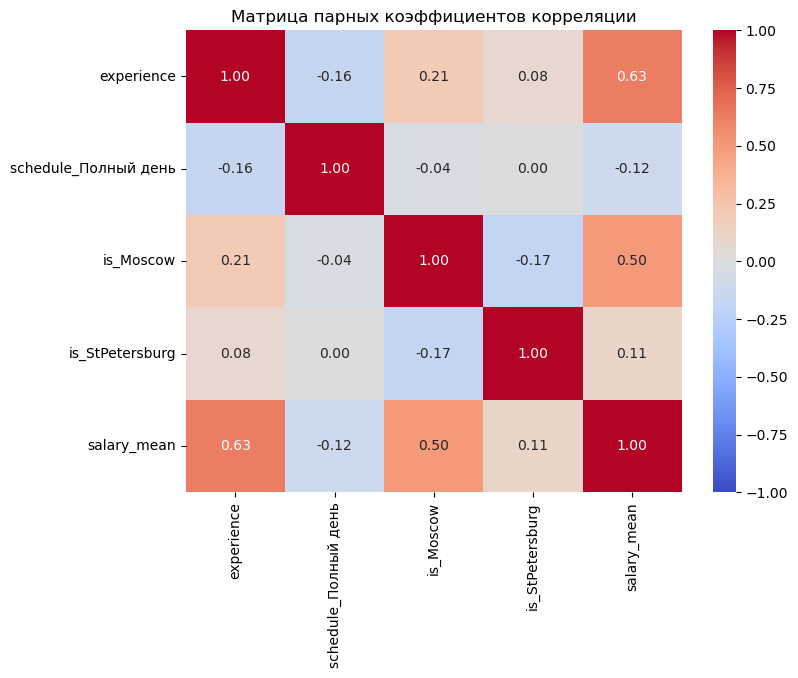

In [292]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = df_selected.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Show the plot
plt.title('Матрица парных коэффициентов корреляции')
plt.show()

Разбиение выборки на train и test

In [127]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
# import statsmodels.api as sm

# # Разбиение на тренировочную и тестовую выборки
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Восстановление модели на тренировочных данных
# model_train = sm.OLS(y_train, X_train).fit()

# # Получение предсказанных значений на тестовой выборке
# predicted_values_test = model_train.predict(X_test)

In [128]:
import statsmodels.api as sm

# Model specification
X = df_selected[['experience', 'schedule_Полный день', 'is_Moscow', 'is_StPetersburg']]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = df_selected['salary_mean']

# Model estimation
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            salary_mean   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     134.0
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           6.64e-75
Time:                        10:37:47   Log-Likelihood:                -5464.7
No. Observations:                 448   AIC:                         1.094e+04
Df Residuals:                     443   BIC:                         1.096e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 6.093e+04 

In [332]:
import statsmodels.api as sm

# Model specification
X = df_selected[['experience', 'is_Moscow', 'is_StPetersburg']]
X = sm.add_constant(X)  # Add a constant term for the intercept
y = df_selected['salary_mean']

# Model estimation
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            salary_mean   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     178.8
Date:                Sun, 17 Dec 2023   Prob (F-statistic):           5.31e-76
Time:                        13:40:20   Log-Likelihood:                -5464.9
No. Observations:                 448   AIC:                         1.094e+04
Df Residuals:                     444   BIC:                         1.095e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.839e+04   4545.427     

In [333]:
model.params

const              58389.199272
experience         50929.664198
is_Moscow          68501.977480
is_StPetersburg    33856.100141
dtype: float64

In [334]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print VIF results
vif_data

,Variable,VIF
0,const,3.977800
1,experience,1.061642
2,is_Moscow,1.087775
3,is_StPetersburg,1.046865


1. Коэффициенты (coef) и P-значения:

2. Коэффициенты для переменных 'experience', 'is_Moscow' и 'is_OtherCity' все статистически значимы (P-value < 0.05), что указывает на их важность в объяснении изменчивости заработной платы.
R-squared и скорректированный R-squared:

3. R-квадрат (0.547) говорит о том, что примерно 54.7% изменчивости заработной платы объясняется вашей моделью. Скорректированный R-квадрат (0.544) учитывает количество предикторов и также является хорошим показателем.
F-статистика:

4. F-статистика (178.8) исключительно высока, а вероятность F-статистики очень низка (5.31e-76), что свидетельствует о статистической значимости модели в целом.
Диагностические статистики:

* Omnibus, Durbin-Watson и Jarque-Bera предоставляют информацию о различных диагностических аспектах. Вероятности Omnibus и Jarque-Bera достаточно высоки, что указывает на нормальность остатков.
Cond. No.:

5. Кондиционное число (Cond. No.) равно 11.3, что хорошо, и не указывает на проблемы с мультиколлинеарностью.

In [335]:
_, p_bp, _, _ = sm.stats.diagnostic.het_breuschpagan(model.resid, X)
print(f"Breusch-Pagan test p-value: {p_bp}")

Breusch-Pagan test p-value: 1.0747984253989181e-05


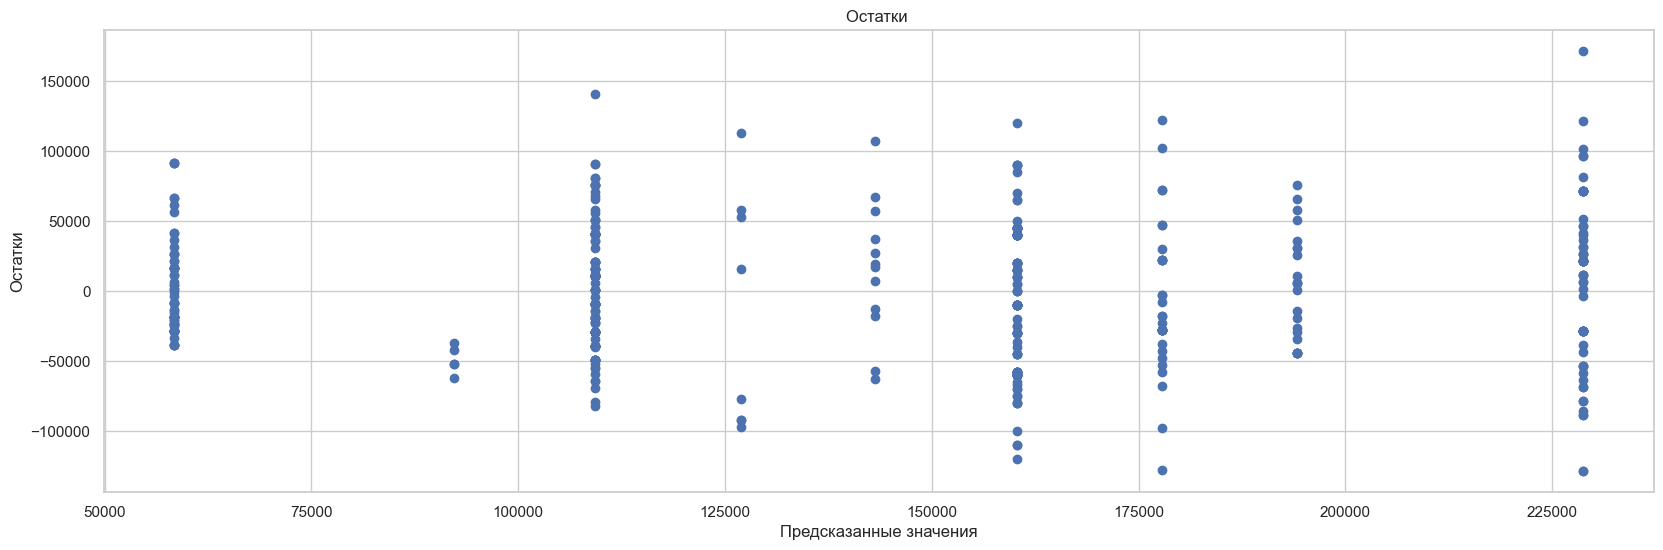

In [329]:
# 4.2.4. Визуализация остатков
plt.scatter(model.fittedvalues, model.resid)
plt.title('Остатки ')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.show()


In [336]:
from statsmodels.stats.diagnostic import het_goldfeldquandt


# Проводим тест Голдфелда-Квандта
gq_test = het_goldfeldquandt(model.resid, X)
print("Goldfeld-Quandt test p-value:", gq_test[1])


Goldfeld-Quandt test p-value: 0.011029536405039835


In [339]:
# Получаем коэффициенты регрессии
coefficients = model.params

# Рассчитайте коэффициенты эластичности для каждого фактора
elasticity_coefficients = coefficients * (X.mean(axis=0) / y.mean())

print("Коэффициенты эластичности для каждого фактора:", elasticity_coefficients)

Коэффициенты эластичности для каждого фактора: const              0.411955
experience         0.452365
is_Moscow          0.114353
is_StPetersburg    0.021327
dtype: float64


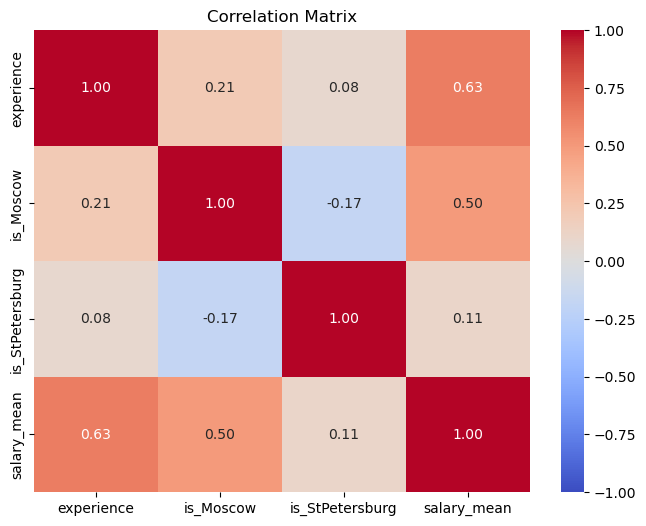

In [130]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = df_selected[['experience', 'is_Moscow', 'is_StPetersburg', 'salary_mean']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Draw the heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

# Show the plot
plt.title('Correlation Matrix')
plt.show()

In [131]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

import numpy as np

# Получаем предсказанные значения
predicted_values = model.predict(X)

# Вычисляем MSE и RMSE
mse = mean_squared_error(y, predicted_values)
rmse = np.sqrt(mse)
# Вычисляем R-squared
r_squared = r2_score(y, predicted_values)

# Вычисляем среднюю абсолютную ошибку (MAE)
mae = mean_absolute_error(y, predicted_values)

# Вычисляем медианную абсолютную ошибку (MedAE)
medae = median_absolute_error(y, predicted_values)


print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared: {r_squared:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Median Absolute Error (MedAE): {medae:.2f}')

Mean Squared Error (MSE): 2306159961.83
Root Mean Squared Error (RMSE): 48022.49
R-squared: 0.5471
Mean Absolute Error (MAE): 38945.72
Median Absolute Error (MedAE): 31249.49


In [132]:
predicted_values

0       92245.299413
1       58389.199272
2       92245.299413
3       58389.199272
5       58389.199272
           ...      
797    228750.505148
801    228750.505148
802    160248.527668
806    194104.627809
807    160248.527668
Length: 448, dtype: float64

In [133]:
df_selected['pred'] = predicted_values
df_selected

,experience,schedule_Полный день,is_Moscow,is_StPetersburg,salary_mean,pred
0,0,1,0,1,40000.0,92245.299413
1,0,0,0,0,30000.0,58389.199272
2,0,0,0,1,55000.0,92245.299413
3,0,1,0,0,70000.0,58389.199272
5,0,1,0,0,35000.0,58389.199272
...,...,...,...,...,...,...
797,2,1,1,0,160000.0,228750.505148
801,2,0,1,0,200000.0,228750.505148
802,2,0,0,0,170000.0,160248.527668
806,2,1,0,1,160000.0,194104.627809


По результатам метрик видно, что модель обладает некоторой степенью точности

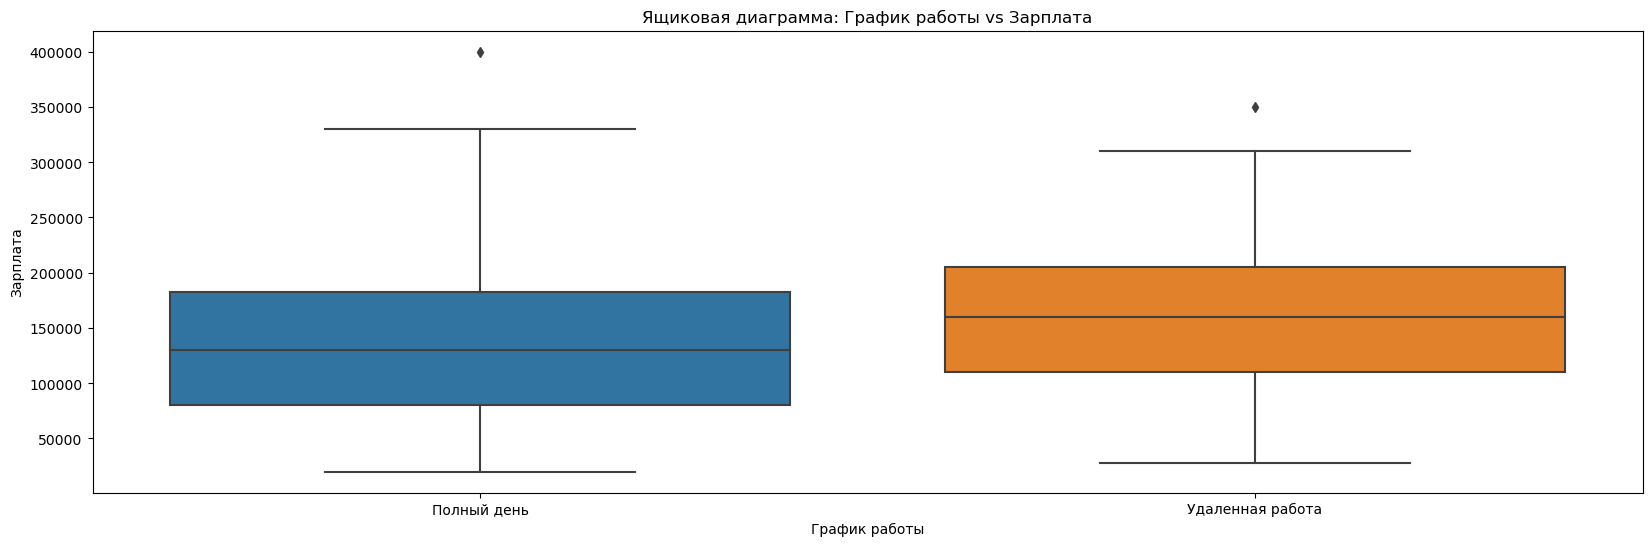

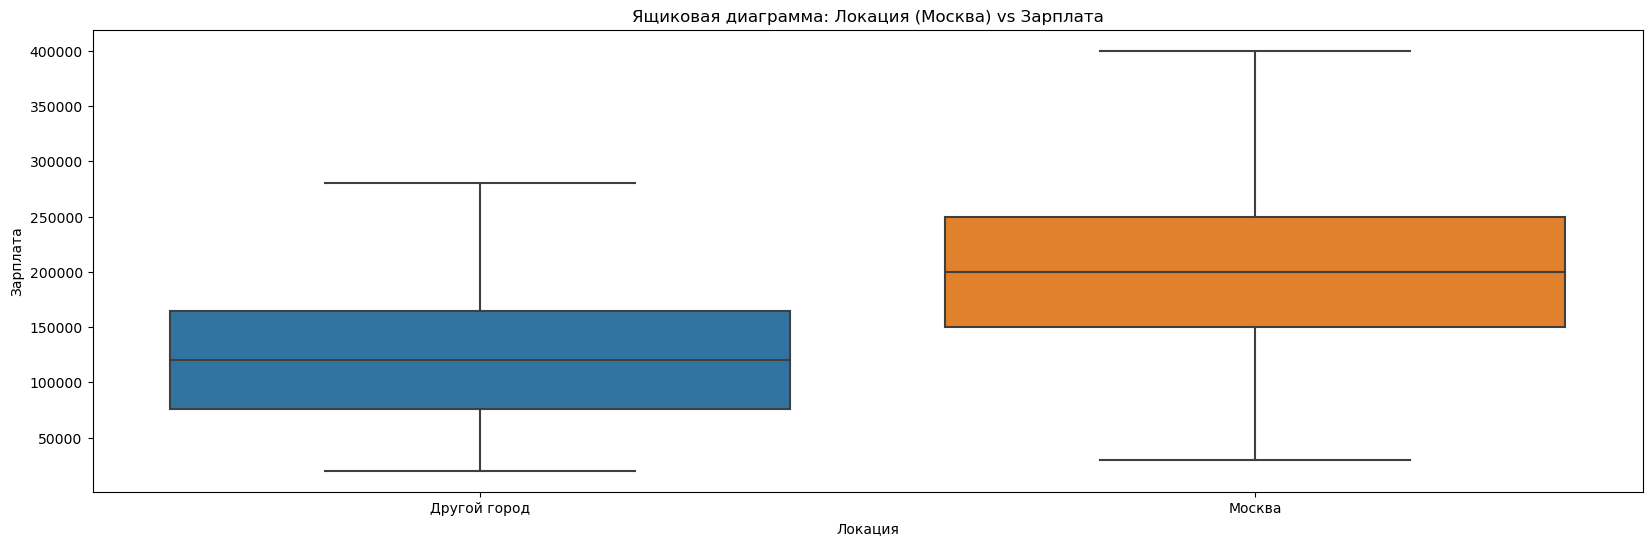

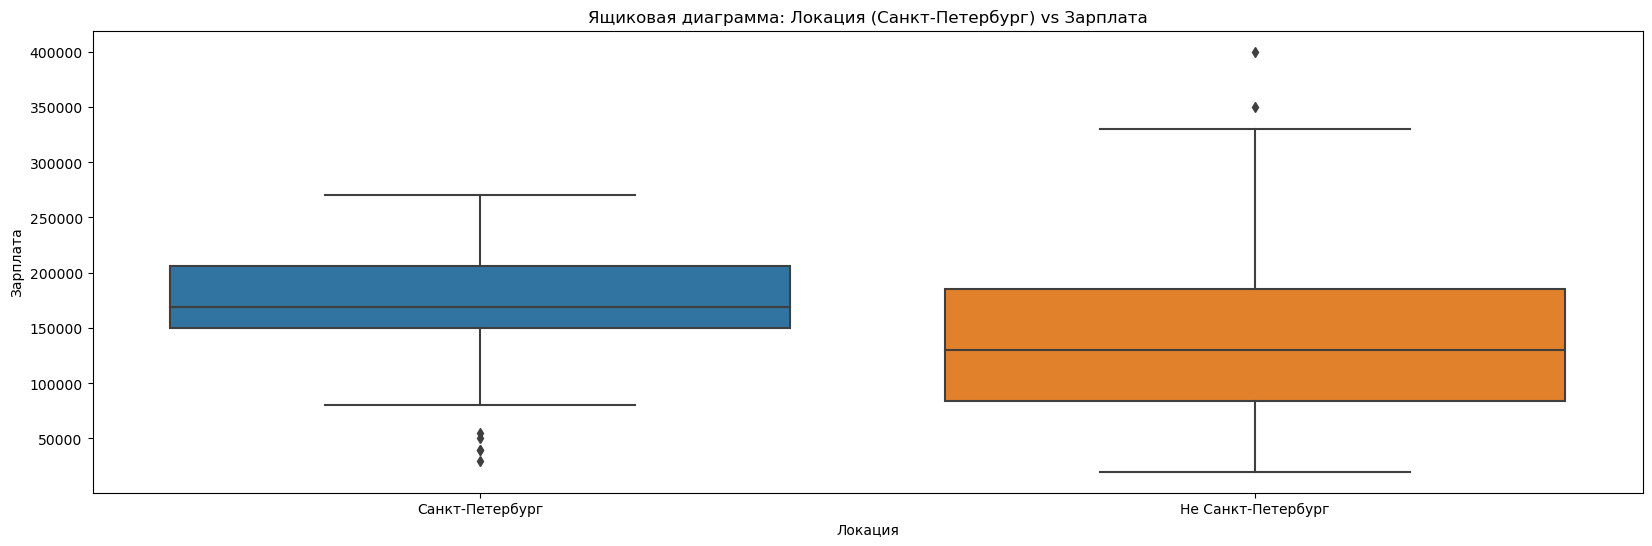

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

df_selected1 = df_selected.copy()
# Замена значений на более понятные подписи
df_selected1['schedule_Полный день'] = df_selected['schedule_Полный день'].map({0: 'Удаленная работа', 1: 'Полный день'})
df_selected1['is_Moscow'] = df_selected['is_Moscow'].map({0: 'Другой город', 1: 'Москва'})
df_selected1['is_StPetersburg'] = df_selected['is_StPetersburg'].map({0: 'Не Санкт-Петербург', 1: 'Санкт-Петербург'})

# Box plot для переменной 'schedule_Полный день' и 'salary_mean'
sns.boxplot(x=df_selected1['schedule_Полный день'], y=df_selected1['salary_mean'])
plt.title('Ящиковая диаграмма: График работы vs Зарплата')
plt.xlabel('График работы')
plt.ylabel('Зарплата')
plt.show()

# Box plot для переменной 'is_Moscow' и 'salary_mean'
sns.boxplot(x=df_selected1['is_Moscow'], y=df_selected1['salary_mean'])
plt.title('Ящиковая диаграмма: Локация (Москва) vs Зарплата')
plt.xlabel('Локация')
plt.ylabel('Зарплата')
plt.show()

# Box plot для переменной 'is_StPetersburg' и 'salary_mean'
sns.boxplot(x=df_selected1['is_StPetersburg'], y=df_selected1['salary_mean'])
plt.title('Ящиковая диаграмма: Локация (Санкт-Петербург) vs Зарплата')
plt.xlabel('Локация')
plt.ylabel('Зарплата')
plt.show()


In [135]:
# Сравнение зарплат при полном и неполном рабочем дне
salary_comparison = df_selected.groupby('schedule_Полный день')['salary_mean'].mean()
salary_comparison

schedule_Полный день
0    156079.646018
1    136898.941791
Name: salary_mean, dtype: float64

In [136]:
salary_comparison = df_selected.groupby('is_StPetersburg')['salary_mean'].mean()
salary_comparison

is_StPetersburg
0    139349.051471
1    166093.312500
Name: salary_mean, dtype: float64

In [137]:
salary_comparison = df_selected.groupby('is_Moscow')['salary_mean'].mean()
salary_comparison

is_Moscow
0    122064.752924
1    205207.547170
Name: salary_mean, dtype: float64

In [138]:
# Подсчет количества вакансий с неполным и полным рабочим днем
schedule_counts = df_selected['schedule_Полный день'].value_counts()
schedule_counts

1    335
0    113
Name: schedule_Полный день, dtype: int64

In [139]:
df_selected

,experience,schedule_Полный день,is_Moscow,is_StPetersburg,salary_mean,pred
0,0,1,0,1,40000.0,92245.299413
1,0,0,0,0,30000.0,58389.199272
2,0,0,0,1,55000.0,92245.299413
3,0,1,0,0,70000.0,58389.199272
5,0,1,0,0,35000.0,58389.199272
...,...,...,...,...,...,...
797,2,1,1,0,160000.0,228750.505148
801,2,0,1,0,200000.0,228750.505148
802,2,0,0,0,170000.0,160248.527668
806,2,1,0,1,160000.0,194104.627809
